In [2]:
from PIL import Image
from scipy.fft import ifft
import numpy as np
import matplotlib.pyplot as plt




In [3]:
image = Image.open("../../data/vehicle-type-detection/pickup/PIC_0.jpg")

print(image.format, image.size, image.mode)

image.show()

JPEG (313, 241) RGB


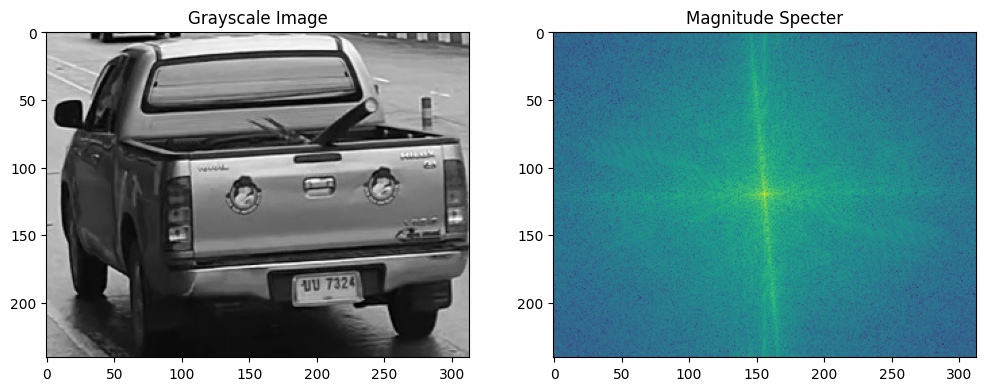

In [4]:
im = image.convert("L")

im_np = np.array(im)

F = np.fft.fft2(im_np)
F_shifted = np.fft.fftshift(F)

magn_spectr = np.log(1+np.abs(F_shifted))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(im_np, cmap="gray")

plt.subplot(1, 2, 2)
plt.imshow(magn_spectr)
plt.title("Magnitude Specter")
plt.show()


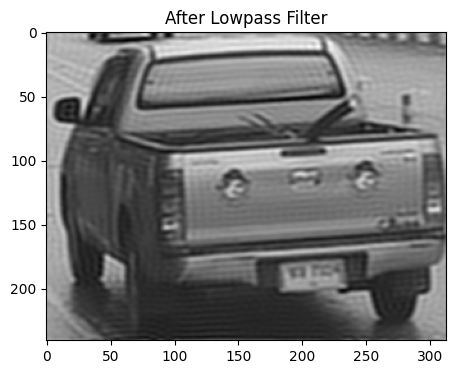

In [5]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 50

mask = np.zeros((rows, cols), dtype=np.uint8)
Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)
mask[dist_from_center <= radius] = 1

F_low = F_shifted * mask

F_ishift = np.fft.ifftshift(F_low)
im_lowpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Lowpass Filter")
plt.imshow(im_lowpass, cmap="gray")

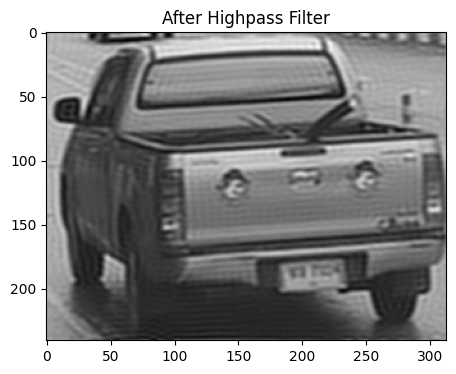

In [6]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 50

Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)

mask = np.ones((rows, cols))
mask[dist_from_center <= radius] = 0

F_high = F_shifted * mask

F_ishift = np.fft.ifftshift(F_high)
im_highpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Highpass Filter")
plt.imshow(im_lowpass, cmap="gray")

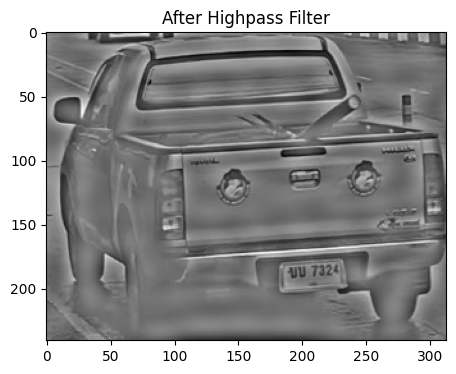

In [7]:
rows, cols = im_np.shape
crow, ccol = rows // 2, cols // 2
radius = 10

mask = np.zeros((rows, cols), dtype=np.uint8)
Y, X = np.ogrid[:rows,:cols]
dist_from_center = np.sqrt((X-ccol)**2 + (Y - crow)**2)
mask[dist_from_center >= radius] = 1

F_high = F_shifted * mask

F_ishift = np.fft.ifftshift(F_high)
im_highpass = np.fft.ifft2(F_ishift).real

plt.figure(figsize=(8, 4))
plt.title("After Highpass Filter")
plt.imshow(im_highpass, cmap="gray")

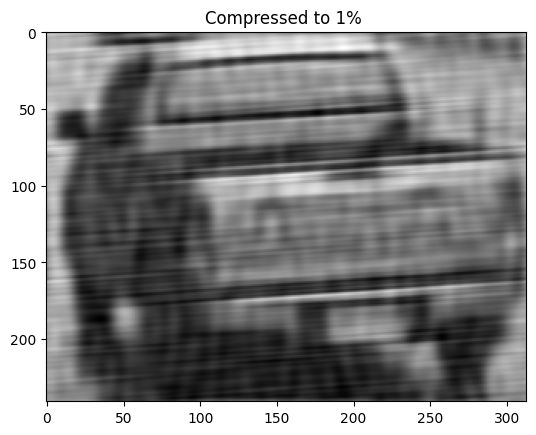

In [8]:
magnitude = np.abs(F_shifted)
compress = 99
threshold = np.percentile(magnitude, compress)
F_compressed = F_shifted * (magnitude >= threshold)

im_compressed = np.fft.ifft2(np.fft.ifftshift(F_compressed)).real

plt.title(f"Compressed to {100 - compress}% ")
plt.imshow(im_compressed, cmap="gray")

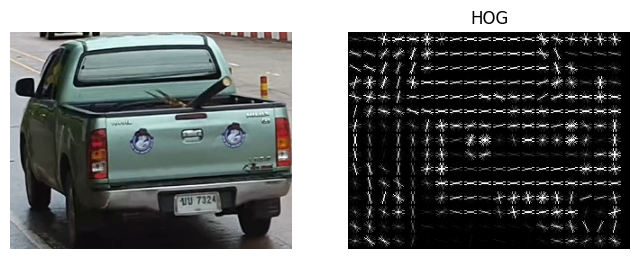

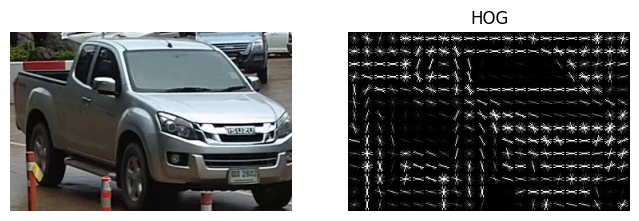

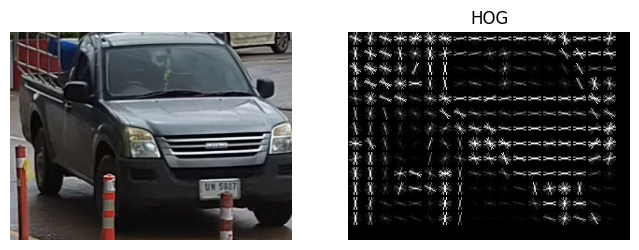

In [9]:
from skimage.feature import hog
from skimage import data, exposure

images = [
    "../../data/vehicle-type-detection/pickup/PIC_0.jpg",
    "../../data/vehicle-type-detection/pickup/PIC_1.jpg",
    "../../data/vehicle-type-detection/pickup/PIC_2.jpg"
]

for path in images:
    image = Image.open(path)
    fd, hog_im = hog(
        image, 
        orientations=8,
        pixels_per_cell=(16, 16),
        cells_per_block=(1,1),
        visualize=True, 
        channel_axis=-1
    )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)

    hog_image_rescaled = exposure.rescale_intensity(hog_im, in_range=(0, 10))

    ax2.axis('off')
    ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    ax2.set_title("HOG")
    plt.show()


In [108]:
images = [
    "../../data/vehicle-type-detection/pickup/PIC_0.jpg",
    "../../data/vehicle-type-detection/motorcycle/PIC_0.jpg",
    "../../data/vehicle-type-detection/suv/PIC_0.jpg",

]

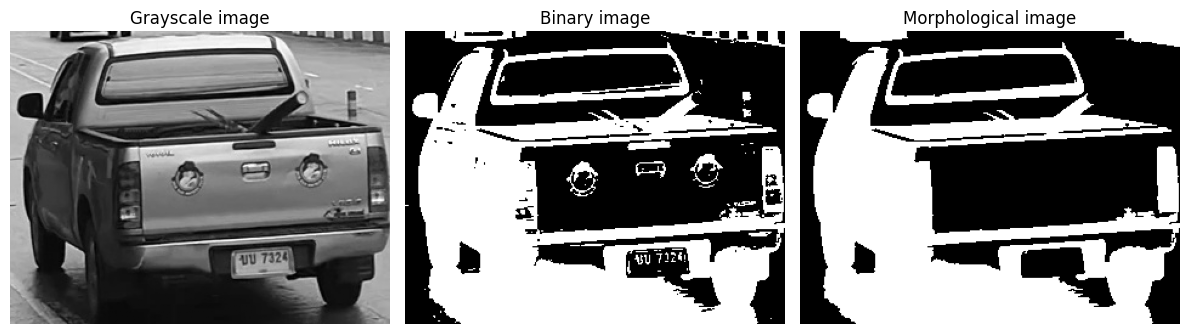

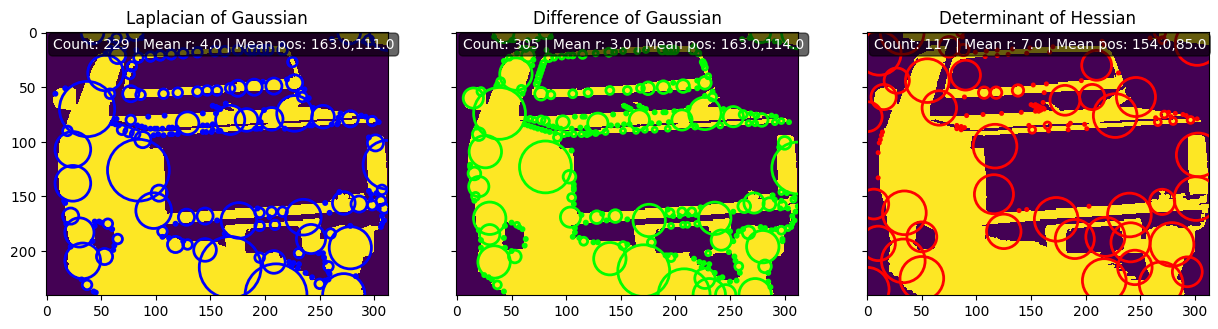

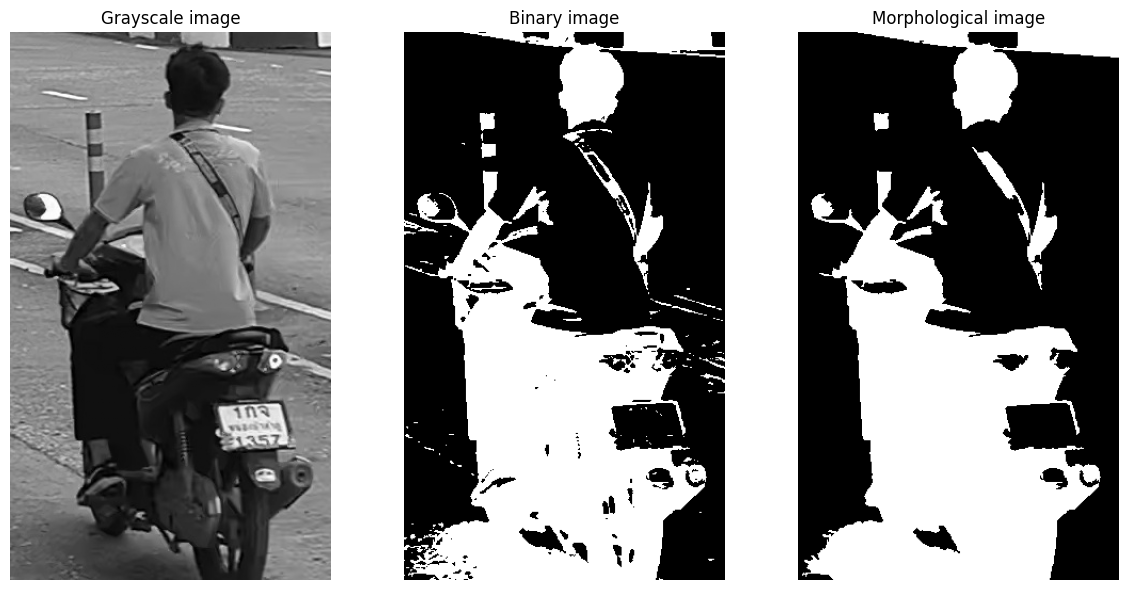

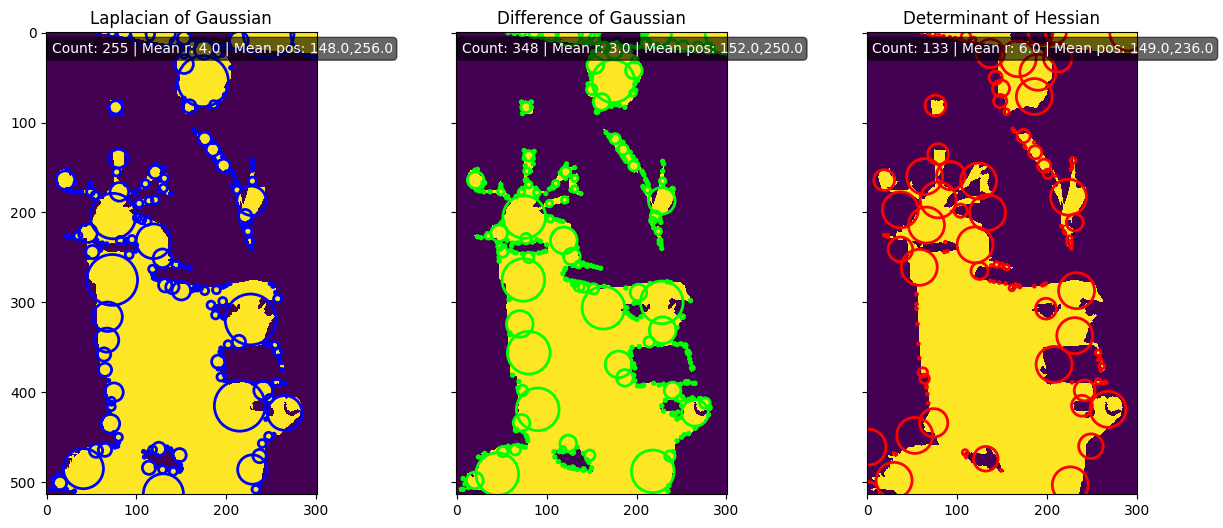

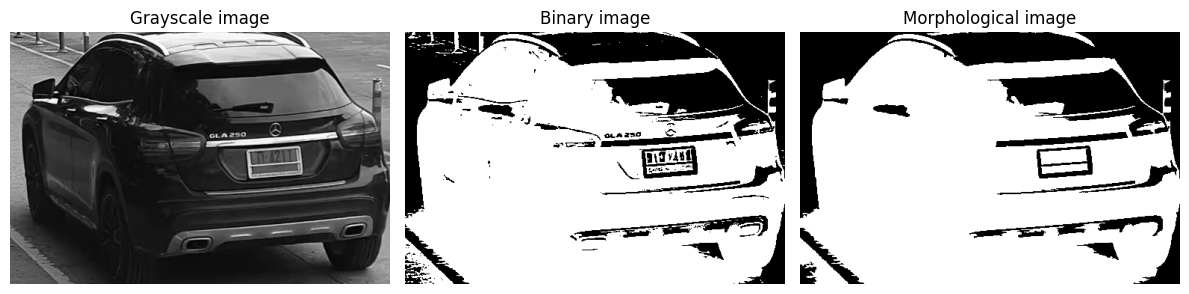

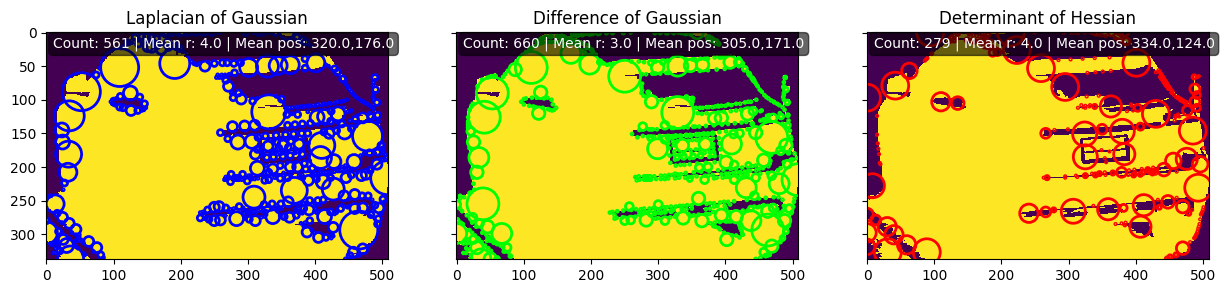

In [109]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from skimage.io import imread, imshow
from skimage.morphology import area_closing, area_opening

threshold = 0.35

for url in images:
    im = rgb2gray(imread(url))
    binary_im = im < threshold

    morph_image = area_closing(area_opening(binary_im, 200), 200)
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))
    axes[0].imshow(im, cmap='gray')
    axes[0].set_title('Grayscale image')
    axes[0].axis('off')
    axes[1].imshow(binary_im, cmap='gray')
    axes[1].set_title('Binary image')
    axes[1].axis('off')
    axes[2].imshow(morph_image, cmap='gray')
    axes[2].set_title('Morphological image')
    axes[2].axis('off')
    plt.tight_layout(); plt.show()

    blobs_log = blob_log(morph_image, max_sigma=20, num_sigma=10, threshold=.1)
    blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

    blobs_dog = blob_dog(morph_image, max_sigma=20, threshold=.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

    blobs_doh = blob_doh(morph_image, max_sigma=20, threshold=.01)

    blob_lists = [blobs_log, blobs_dog, blobs_doh]
    colors = ['blue', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']

    fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
    axis = axes.ravel()

    stats = []
    for idx, (blobs, color, title) in enumerate(zip(blob_lists, colors, titles)):
        axis[idx].set_title(title)
        axis[idx].imshow(morph_image, interpolation='nearest')

        count_blobs = len(blobs)
        for blob in blobs:
            y, x, r = blob
            circle = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            axis[idx].add_patch(circle)
            sum_r += r
        
        # Mean radius
        mean_radius = sum_r / count_blobs


        if len(blobs) > 0:
            y = blobs[:, 0]
            x = blobs[:, 1]
            r = blobs[:, 2]

            mean_number_of_blobs = len(blobs) / len(images)
            mean_r, std_r = np.mean(r), np.std(r)
            mean_x, std_x = np.mean(x), np.std(x)
            mean_y, std_y = np.mean(y), np.std(y)
        else:
            mean_number_of_blobs = 0
            mean_r = std_r = mean_x = std_x = mean_y = std_y = np.nan

        axis[idx].text(
            0.02, 0.98,
            f'Count: {count_blobs} | Mean r: {mean_r.round()} | Mean pos: {mean_x.round()},{mean_y.round()}',
            transform=axis[idx].transAxes,
            fontsize=10,
            color='white',
            verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.6)
        )

        stats.append({
            'method': title,
            'n_blobs': mean_number_of_blobs,
            'mean_r': mean_r,
            'std_r': std_r,
            'mean_x': mean_x,
            'std_x': std_x,
            'mean_y': mean_y,
            'std_y': std_y
        })




In [110]:
import pandas as pd

df = pd.DataFrame(stats)
display(df)
    

,method,n_blobs,mean_r,std_r,mean_x,std_x,mean_y,std_y
0,Laplacian of Gaussian,187.0,3.665359,4.092380,319.536542,134.894965,175.693405,92.703880
1,Difference of Gaussian,220.0,2.743756,3.549882,305.009091,143.134838,171.021212,94.478021
2,Determinant of Hessian,93.0,3.686181,5.319303,334.462366,141.671453,124.422939,99.095951


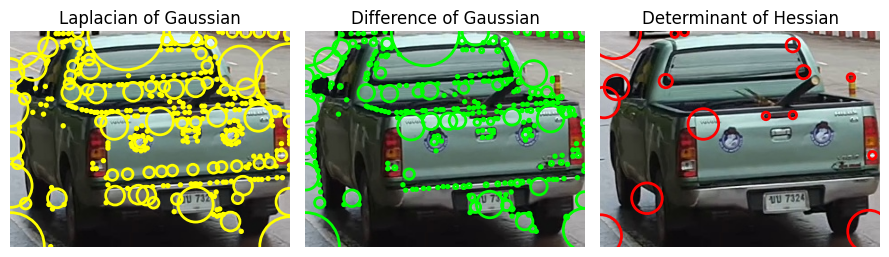

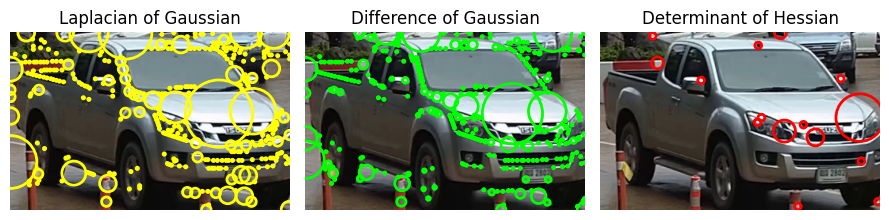

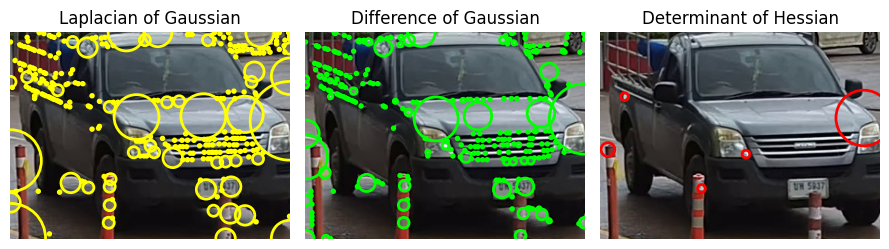

In [ ]:
from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import matplotlib.pyplot as plt

for url in images:
        
    image = Image.open(url)
    image_gray = rgb2gray(image)

    blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=0.1)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=0.1)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        ax[idx].imshow(image)
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()
    
    plt.tight_layout()
    plt.show()